# ECCITE 1D/2D Analysis

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import itertools
from pybedtools import BedTool
import statsmodels.formula.api as smf
import statsmodels.api as sm

import os
import pickle as pkl
%matplotlib inline

In [2]:
pd.set_option('max_columns', None)
pd.set_option('display.max_rows', 500)

In [3]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.7-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento

In [4]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium',
         'axes.labelsize': 'large'}
pylab.rcParams.update(params)

In [5]:
data_path = '/data_volume/memento/eccite/'

In [7]:
adata = sc.read('/data_volume/cas9ProcessedAneuploidy.h5ad')

In [8]:
adata.X[:5, :5].todense()

matrix([[-0.06945229, -0.0992393 , -0.0256175 , -0.01427605, -0.23589087],
        [-0.04266223, -0.11626327, -0.00587893, -0.03732387, -0.2390637 ],
        [-0.07015684, -0.1028458 , -0.02532544, -0.01706812, -0.24195085],
        [-0.04058887, -0.12370155, -0.00312668, -0.04423795, -0.24858417],
        [-0.03756792, -0.08025537, -0.00997758, -0.00881174, -0.18019803]],
       dtype=float32)

In [25]:
adata.obs['q'] = 0.15

In [26]:
memento.setup_memento(adata, q_column='q', filter_mean_thresh=0.07 ,trim_percent=0.05)

Version 0.0.6


/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.7-py3.8.egg/memento/main.py:70: RankWarning: Polyfit may be poorly conditioned
  all_res_var = estimator._residual_variance(all_m, all_v, estimator._fit_mv_regressor(all_m, all_v))


### Read the guide labled perturb-seq data

From perturbseq paper

In [9]:
adata = sc.read(data_path + 'eccite.h5ad')
adata = adata[(adata.obs['replicate'] != 'rep4')].copy()
adata.var.index.name=None

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [10]:
adata.obs.head(2)

,lane,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,orig.ident,nCount_HTO,nFeature_HTO,MULTI_ID,MULTI_classification,replicate,treatment,guide_ID,second_percent,gene
GACGGCTGTTTGACTG-8,8,1755,5233.0,279.0,5.331550,SeuratProject,265,5,rep2-tx-TCGATAATGCGA,rep2-tx-TCGATAATGCGA,rep2,tx,IRF7g1-CGTGTAGCGCAGCTGCTTC,0.006061,IRF7
GCAGCCATCCGTACAA-6,6,2219,7110.0,525.0,7.383966,SeuratProject,104,5,rep1-tx-AGGACCATCCAA,rep1-tx-AGGACCATCCAA,rep1,tx,IRF7g1-CGTGTAGCGCAGCTGCTTC,0.076923,IRF7


In [11]:
adata.obs['treatment'].value_counts()

tx      19822
ctrl     2046
Name: treatment, dtype: int64

### Read pre-defined ISGs

In [12]:
isg_classes = pd.read_csv('isg_classes.csv')

In [13]:
t1_isg = isg_classes.query('overall_type =="type1"').gene.tolist()
t2_isg = isg_classes.query('overall_type =="type2"').gene.tolist()
shared_isg = isg_classes.query('overall_type == "shared"').gene.tolist()
all_isg = isg_classes[isg_classes.sum(axis=1) > 0].gene.tolist()

/tmp/ipykernel_6286/2285624001.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  all_isg = isg_classes[isg_classes.sum(axis=1) > 0].gene.tolist()


### Setup memento

In [14]:
adata.obs['q'] = 0.15

In [15]:
memento.setup_memento(adata, q_column='q', filter_mean_thresh=0.07 ,trim_percent=0.05)

Version 0.0.6


/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.7-py3.8.egg/memento/main.py:70: RankWarning: Polyfit may be poorly conditioned


In [16]:
ko_genes = adata.obs.gene.drop_duplicates().tolist()

### Memento - WT vs KO

In [ ]:
for treatment in ['ctrl', 'tx']:
    for g in ko_genes:

        if g == 'NT':
            continue

        subset = adata[adata.obs['gene'].isin(['NT', g]) & (adata.obs['treatment']==treatment)].copy().copy()

        subset.obs['is_ko'] = subset.obs.guide_ID.str.contains(g).values
        
        memento.create_groups(subset, label_columns=['is_ko', 'replicate'])

        memento.compute_1d_moments(subset, min_perc_group=.7)

        memento.ht_1d_moments(
            subset, 
            formula_like='1 + is_ko + replicate',
            treatment_col='is_ko', 
            num_boot=10000, 
            verbose=1,
            resampling='permutation',
            approx=False,
            num_cpus=94)

        subset.write(data_path + '1d/{}_{}.h5ad'.format(g, treatment)) 


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    4.4s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:    5.4s
[Parallel(n_jobs=94)]: Done 612 tasks      | elapsed:    6.7s
[Parallel(n_jobs=94)]: Done 1062 tasks      | elapsed:    8.2s
[Parallel(n_jobs=94)]: Done 1612 tasks      | elapsed:   10.1s
[Parallel(n_jobs=94)]: Done 2262 tasks      | elapsed:   12.5s
[Parallel(n_jobs=94)]: Done 3012 tasks      | elapsed:   15.0s
[Parallel(n_jobs=94)]: Done 3862 tasks      | elapsed:   17.9s
[Parallel(n_jobs=94)]: Done 4812 tasks      | elapsed:   21.6s
[Parallel(n_jobs=94)]: Done 5614 out of 5614 | elapsed:   24.3s finished
...

### Memento - ctrl vs stim 1D

In [17]:
subset = adata[adata.obs['gene'].isin(['NT'])].copy().copy()

subset.obs['is_stim'] = (subset.obs['treatment'] == 'tx').astype(int)

memento.create_groups(subset, label_columns=['is_stim', 'replicate'])

memento.compute_1d_moments(subset, min_perc_group=.7)

memento.ht_1d_moments(
    subset, 
    formula_like='1 + is_stim + replicate',
    treatment_col='is_stim', 
    num_boot=10000, 
    verbose=1,
    resampling='permutation',
    approx=False,
    num_cpus=92)

subset.write(data_path + 'ctrl_vs_tx.h5ad')

[Parallel(n_jobs=92)]: Using backend LokyBackend with 92 concurrent workers.
[Parallel(n_jobs=92)]: Done  16 tasks      | elapsed:    4.5s
[Parallel(n_jobs=92)]: Done 266 tasks      | elapsed:    6.9s
[Parallel(n_jobs=92)]: Done 616 tasks      | elapsed:   10.3s
[Parallel(n_jobs=92)]: Done 1066 tasks      | elapsed:   14.6s
[Parallel(n_jobs=92)]: Done 1616 tasks      | elapsed:   19.1s
[Parallel(n_jobs=92)]: Done 2266 tasks      | elapsed:   24.4s
[Parallel(n_jobs=92)]: Done 3016 tasks      | elapsed:   31.2s
[Parallel(n_jobs=92)]: Done 3866 tasks      | elapsed:   38.4s
[Parallel(n_jobs=92)]: Done 4816 tasks      | elapsed:   46.3s
[Parallel(n_jobs=92)]: Done 5866 tasks      | elapsed:   55.1s
[Parallel(n_jobs=92)]: Done 7016 tasks      | elapsed:  1.1min
[Parallel(n_jobs=92)]: Done 8325 out of 8325 | elapsed:  1.3min finished
... storing 'memento_group' as categorical


In [18]:
stim_ht_df = memento.get_1d_ht_result(subset)
stim_ht_df['de_fdr'] = memento.util._fdrcorrect(stim_ht_df['de_pval'])

In [19]:
thp1_isgs = stim_ht_df.query('de_fdr < 0.05 & de_coef > 0.5').gene.tolist()

In [20]:
len(thp1_isgs)

1505

### Memento - ctrl vs stim 2D moments

In [33]:
tf_df = pd.read_csv('human_tf.txt', sep='\t')
tf_df = tf_df.query('Family != "Others"')
tf_list = tf_df['Symbol'].tolist()
tf_list += ['CIITA', 'NLRC5']

In [35]:
subset = adata[adata.obs['gene'].isin(['NT'])].copy().copy()

subset.obs['is_stim'] = (subset.obs['treatment'] == 'tx').astype(int)

memento.create_groups(subset, label_columns=['is_stim', 'replicate'])

memento.compute_1d_moments(subset, min_perc_group=.7)

available_tfs = list(set(tf_list) & set(subset.var.index))
available_targets = list(set(thp1_isgs) & set(subset.var.index))

memento.compute_2d_moments(subset, list(itertools.product(available_tfs, available_targets) )   )

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [36]:
moments_2d = memento.get_2d_moments(subset, groupby='is_stim')

In [38]:
moments_2d['diff'] = moments_2d['is_stim_1'] - moments_2d['is_stim_0']

In [39]:
df = []
for tf in available_tfs:
    pv = stats.ttest_1samp(moments_2d.query('gene_1 == "{}"'.format(tf)).dropna()['diff'].values, popmean=0)[1]
    corr = moments_2d.query('gene_1 == "{}"'.format(tf)).dropna()['diff'].values.mean()
    df.append((tf, corr, pv))    
    
df = pd.DataFrame(df, columns=['tf','corr', 'pv'])

In [44]:
hbec_df = pd.read_csv('/data_volume/memento/hbec/ifng_2d_moments.csv')

In [46]:
joined = hbec_df.merge(df, on='tf', suffixes=('_hbec', '_eccite'))

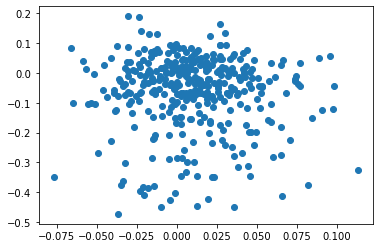

In [48]:
plt.scatter(joined['corr_hbec'], joined['corr_eccite'])

### Memento - ctrl vs stim 2D

In [21]:
hbec_2d_df = pd.read_csv('/data_volume/temp.csv', index_col=0)

In [22]:
tfs = hbec_2d_df['gene_1'].drop_duplicates().tolist()

In [ ]:
subset = adata[adata.obs['gene'].isin(['NT'])].copy().copy()

subset.obs['is_stim'] = (subset.obs['treatment'] == 'tx').astype(int)

memento.create_groups(subset, label_columns=['is_stim', 'replicate'])

memento.compute_1d_moments(subset, min_perc_group=.7)

available_tfs = list(set(tfs) & set(subset.var.index))
available_targets = list(set(thp1_isgs) & set(subset.var.index))

memento.compute_2d_moments(subset, list(itertools.product(available_tfs, available_targets) )   )

memento.ht_2d_moments( 
    subset, 
    formula_like='1 + is_stim',
    treatment_col='is_stim', 
    num_boot=10000, 
    verbose=1,
    num_cpus=92,
    resampling='permutation',
    approx=True)
# subset.write(data_path + 'ctrl_vs_tx_2d.h5ad')

In [24]:
stim_2d_ht = memento.get_2d_ht_result(subset)

In [29]:
moments = memento.get_2d_moments(subset, groupby='is_stim')

(array([3930., 2274., 1996., 1900., 1868., 1817., 1809., 1861., 1773.,
        1836.]),
 array([7.91671319e-06, 1.00007125e-01, 2.00006333e-01, 3.00005542e-01,
        4.00004750e-01, 5.00003958e-01, 6.00003167e-01, 7.00002375e-01,
        8.00001583e-01, 9.00000792e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

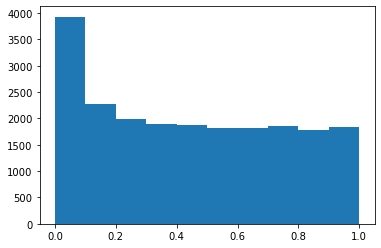

In [27]:
plt.hist(stim_2d_ht['corr_pval'])

In [50]:
sig_joined = hbec_2d_df.merge(stim_2d_ht, on=['gene_1', 'gene_2'])

In [55]:
hbec_2d_df.shape

(230, 6)

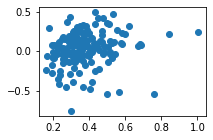

In [63]:
plt.figure(figsize=(3,2))
plt.scatter(sig_joined['corr_coef_x'], sig_joined['corr_coef_y'])

In [53]:
stats.spearmanr(sig_joined['corr_coef_x'], sig_joined['corr_coef_y'])

SpearmanrResult(correlation=0.2567062248096731, pvalue=0.0006053278254260729)

### Analyze 1D - ctrl

In [9]:
results = {}
moments = {}
for treatment in ['ctrl', 'tx']:
    results[treatment] = {}
    moments[treatment] = {}
    for g in ['STAT1']:#ko_genes:
    #     print(g)
        if g == 'NT': continue
        subset = sc.read(data_path +'1d/{}_{}.h5ad'.format(g, treatment))
        df = memento.get_1d_ht_result(subset)
        df['de_fdr'] = memento.util._fdrcorrect(df['de_pval'])
        df['dv_fdr'] = memento.util._fdrcorrect(df['dv_pval'])
        moment_df = memento.get_1d_moments(subset, groupby='is_ko')
        results[treatment][g] = df.copy()
        moments[treatment][g] = (moment_df[0].copy(), moment_df[1].copy())

/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:523: RuntimeWarning: divide by zero encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:550: RuntimeWarning: divide by zero encountered in log


In [28]:
moment_df = moments['ctrl'][g]

In [35]:
moment_df = moments['ctrl']['STAT1']
ctrl_df = pd.melt(moment_df[1][moment_df[1]['gene'].isin(set(thp1_isgs) & set(t1_isg))], id_vars=['gene'])
ctrl_df['stim'] = 'CTRL'
moment_df = moments['tx']['STAT1']
stim_df = pd.melt(moment_df[1][moment_df[1]['gene'].isin(set(thp1_isgs) & set(t1_isg))], id_vars=['gene'])
stim_df['stim'] = 'IFNG'

In [36]:
combined_df = pd.concat([ctrl_df, stim_df])

In [37]:
combined_df.head(5)

,gene,variable,value,stim
0,ISG15,is_ko_False,2.014224,CTRL
1,IFI6,is_ko_False,2.749943,CTRL
2,MTMR11,is_ko_False,0.879598,CTRL
3,IFI16,is_ko_False,1.361764,CTRL
4,CMPK2,is_ko_False,1.513613,CTRL


In [38]:
combined_df['KO'] = (combined_df['variable']=='is_ko_True')

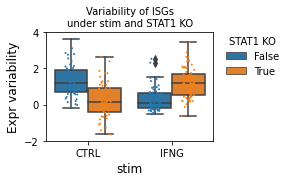

In [40]:
plt.figure(figsize=(3,2))
sns.boxplot(x='stim', y='value', hue='KO', data=combined_df)

ax = sns.stripplot(x='stim', y='value', hue='KO', data=combined_df, lw=1,dodge=True, jitter=0.15, size=2)
handles, labels = ax.get_legend_handles_labels()
plt.ylim(-2, 4)
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='STAT1 KO', frameon=False)
plt.title('Variability of ISGs\nunder stim and STAT1 KO')
plt.ylabel('Expr variability')
plt.savefig('ko_variability.png', bbox_inches='tight', dpi=1000)

In [27]:
# for g in ko_genes:
#     print(g, results[g].query('de_fdr < 0.1').shape[0],results[g].query('dv_fdr < 0.1').shape[0])

In [33]:
df['de_fdr'].min()

0.011924324558855231

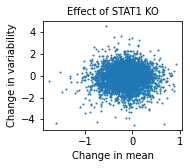

In [29]:
tf = 'STAT1'
plt.figure(figsize=(2.5,2))
plt.scatter(results[tf]['de_coef'], results[tf]['dv_coef'], s=1)
plt.title('Effect of {} KO'.format(tf));
plt.xlabel('Change in mean'); plt.ylabel('Change in variability')
plt.scatter(results[tf].query('dv_fdr < 0.1 & dv_coef > 0')['de_coef'], results[tf].query('dv_fdr < 0.1 & dv_coef > 0')['dv_coef'], s=5)
plt.scatter(results[tf].query('dv_fdr < 0.1 & dv_coef < 0')['de_coef'], results[tf].query('dv_fdr < 0.1 & dv_coef < 0')['dv_coef'], s=5)

# plt.savefig('figures/variability_{}.png'.format(tf), bbox_inches='tight', dpi=800)

In [ ]:
plt.figure(figsize=(2.5,2))
plt.scatter(results['STAT1']['de_coef'], results['STAT1']['dv_coef'], s=0.1)
plt.title('Effect of STAT1 KO');
plt.xlabel('Change in mean'); plt.ylabel('Change in variability')
plt.scatter(results['STAT1'].query('dv_fdr < 0.1 & dv_coef > 0')['de_coef'], results['STAT1'].query('dv_fdr < 0.1 & dv_coef > 0')['dv_coef'], s=1)
# plt.savefig('figures/variability.png', bbox_inches='tight', dpi=800)

In [134]:
results['IFNGR1'].query('gene == "IFNGR1"')

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,de_fdr,dv_fdr
3183,IFNGR1,-0.150763,0.045791,0.001701,0.199772,0.201333,0.314369,0.006115,0.849193


### Read DE genes

In [15]:
results = {}
means = {}
for g in ko_genes:
#     print(g)
    if g == 'NT': continue
    subset = sc.read(data_path +'1d/{}_tx_guide_rep.h5ad'.format(g))
    df = memento.get_1d_ht_result(subset)
    df['de_fdr'] = memento.util._fdrcorrect(df['de_pval'])
    df['dv_fdr'] = memento.util._fdrcorrect(df['dv_pval'])
    results[g] = df.copy()

### Run select

In [87]:
# subset_ko_genes = ['STAT1', 'STAT2', 'JAK2', 'IFNGR1', 'IFNGR2', 'IRF1']
subset_ko_genes = ['STAT1', 'JAK2', 'IFNGR1', 'IFNGR2']
tfs = ['MBD4',
 'FOSL2',
 'RELA',
 'JUN',
 'TGIF1',
 'ZNF644',
 'FOS',
 'SOX4',
 'ZNF766',
 'ZNF276',
 'BHLHE40',
 'PITX1',
 'MLX',
 'HMGB1',
 'ZNF592',
 'YBX1',
 'STAT3',
 'KLF6',
 'USF2',
 'HEY2']
done_files = os.listdir(data_path + '2d/')
results = {}
for g in ['STAT1', 'JAK2', 'IFNGR1', 'IFNGR2', 'IRF1']:
    

    if g == 'NT': continue
    fname = '{}_with_{}_permutation.h5ad'.format(g, g)
    if fname in done_files: continue

    subset = adata.copy().copy()

    subset = adata[adata.obs['gene'].isin(['NT', g]) & (adata.obs['treatment']=='tx')].copy().copy()

    subset.obs['is_ko'] = subset.obs.guide_ID.str.contains(g).astype(int).values

    memento.create_groups(subset, label_columns=['is_ko', 'replicate'])

    memento.compute_1d_moments(subset, min_perc_group=.7)

    if g not in subset.var.index: continue

    available_tfs = list(set(tfs) & set(subset.var.index))
    available_targets = list(set(thp1_isgs) & set(subset.var.index))
    memento.compute_2d_moments(subset, list(itertools.product(available_tfs, available_targets))   )

#     memento.ht_2d_moments( 
#         subset, 
#         formula_like='1 + is_ko + replicate',
#         treatment_col='is_ko', 
#         num_boot=10000, 
#         verbose=1,
#         num_cpus=90,
#         resampling='permutation',
#         approx=True)

    subset.write(data_path + '2d/selected_TFs_with_{}_KO.h5ad'.format(g))

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
... storing 'memento_group' as categorical
... storing 'memento_group' as categorical
... storing 'memento_group' as categorical
... storing 'memento_group' as categorical
... storing 'memento_group' as categorical


In [209]:
subset = sc.read(data_path + '2d/selected_TFs_with_IFNGR1_KO.h5ad')
# df = memento.get_2d_ht_result(subset)
df = memento.get_2d_moments(subset, groupby='is_ko')#.query('is_ko_0 > 0.3')
# df = df.merge(moments, on=['gene_1', 'gene_2'])

In [ ]:

for tf in tfs:
    plt.figure()
    sns.kdeplot(df.query('gene_1 == "{}"'.format(tf)).is_ko_0)
    sns.kdeplot(df.query('gene_1 == "{}"'.format(tf)).is_ko_1)
    plt.title(tf)

<AxesSubplot:xlabel='is_ko_0', ylabel='Density'>

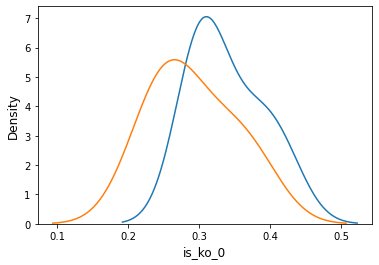

In [208]:
tf = 'FOS'
sns.kdeplot(df.query('gene_1 == "{}"'.format(tf)).is_ko_0)
sns.kdeplot(df.query('gene_1 == "{}"'.format(tf)).is_ko_1)

In [44]:
df['corr_fdr'] = memento.util._fdrcorrect(df['corr_pval'])

In [29]:
df.query('corr_fdr < 0.1')

,gene_1,gene_2,corr_coef,corr_se,corr_pval,corr_fdr


In [27]:
df.query('gene_1 == "FOS"')

,gene_1,gene_2,corr_coef,corr_se,corr_pval
1160,FOS,PIM1,0.016741,0.059169,0.776822
1161,FOS,MAP1LC3B,-0.049080,0.051924,0.345465
1162,FOS,GK,0.042563,0.052588,0.419958
1163,FOS,RALGDS,0.090831,0.053516,0.089191
1164,FOS,PSMB10,-0.109940,0.047803,0.021698
...,...,...,...,...,...
1735,FOS,SIPA1L3,-0.234078,0.075820,0.002100
1736,FOS,GPR65,0.089034,0.067118,0.185381
1737,FOS,IFI27,-0.049195,0.039169,0.209779
1738,FOS,SNX20,-0.026632,0.058666,0.652635


### 1D change for TFs

In [16]:
a = results['IFNGR1']

In [21]:
top_gamma_tfs = ['MBD4',
 'FOSL2',
 'RELA',
 'JUN',
 'TGIF1',
 'ZNF644',
 'FOS',
 'SOX4',
 'ZNF766',
 'ZNF276',
 'BHLHE40',
 'PITX1',
 'MLX',
 'HMGB1',
 'ZNF592',
 'YBX1',
 'STAT3',
 'KLF6',
 'USF2',
 'HEY2']
de_tfs = ['STAT1', 'IRF1']

In [ ]:
tf_df = pd.read_csv('../baseline/human_tf.txt', sep='\t')
tf_df = tf_df.query('Family != "Others"')
tf_list = tf_df['Symbol'].tolist()
tf_list += ['CIITA', 'NLRC5']

In [25]:
a[a.gene.isin(de_tfs)]

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,de_fdr,dv_fdr
1361,STAT1,-0.918483,0.024827,9.590841e-08,1.200798,0.073786,0.000006,0.000026,0.002669
2468,IRF1,-1.499877,0.037202,1.403768e-08,1.586197,0.068810,0.000069,0.000018,0.010618


In [23]:
a[a.gene.isin(top_gamma_tfs)]

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,de_fdr,dv_fdr
279,YBX1,-0.011982,0.016835,4.812519e-01,-0.064339,0.044935,0.163784,0.570752,0.683930
361,JUN,-0.288426,0.028473,8.374337e-06,-0.239816,0.084530,0.010899,0.000157,0.204870
421,ZNF644,-0.020409,0.036099,5.772423e-01,-0.132945,0.205027,0.606339,0.658839,0.915977
1023,FOSL2,-0.256414,0.063890,6.521654e-04,-0.039555,0.251765,0.888311,0.002059,0.974591
1494,BHLHE40,0.129073,0.043836,3.299670e-03,-0.061946,0.145581,0.690431,0.007466,0.935422
1802,MBD4,0.139841,0.031519,1.951493e-04,-0.067437,0.151725,0.669833,0.000888,0.930165
2681,SOX4,0.050662,0.049320,3.030697e-01,-0.080867,0.127313,0.538846,0.392672,0.895913
4132,KLF6,-0.172576,0.033737,1.002724e-04,-0.365830,0.105520,0.001900,0.000586,0.061479
4629,RELA,-0.095232,0.049086,5.329467e-02,-0.317178,0.254344,0.226577,0.088116,0.745596
5318,HMGB1,0.199049,0.029373,3.439061e-04,-0.042079,0.067495,0.561144,0.001289,0.902437


### Run validation 2D test

In [70]:
hbec_df = pd.read_csv('/data_volume/temp.csv', index_col=0)

In [41]:
tfs = ['FOS', 'BHLHE40', 'SOX4']

In [67]:
len(adata.obs.gene.drop_duplicates().tolist())

27

In [69]:
hbec_df

,tf,corr,pv,log10(P),de_fdr,de_coef
0,MBD4,0.081809,2.899620e-23,22.537659,0.721298,0.042312
1,IRF6,-0.076351,8.709737e-23,22.059995,0.438932,0.059682
2,IRF7,-0.064989,9.881039e-23,22.005197,0.001080,0.301630
3,FOSL2,0.076724,4.185279e-22,21.378276,0.856891,0.032854
4,GTF2I,-0.053861,2.364870e-21,20.626193,0.056388,0.071996
...,...,...,...,...,...,...
557,ZFP62,0.000506,9.671199e-01,0.014520,0.746111,-0.071165
558,ZNF585A,0.000275,9.721501e-01,0.012267,0.218829,-0.187578
559,ELK3,-0.000096,9.878336e-01,0.005316,0.022634,-0.155086
560,ZNF605,0.000109,9.899115e-01,0.004404,0.658620,0.106605


In [72]:
for g in adata.obs.gene.drop_duplicates().tolist():
    
    print(g)
    if g == 'NT': continue

    subset = adata.copy().copy()

    subset = adata[adata.obs['gene'].isin(['NT', g]) & (adata.obs['treatment']=='tx')].copy().copy()

    subset.obs['is_ko'] = subset.obs.guide_ID.str.contains(g).astype(int).values

    memento.create_groups(subset, label_columns=['is_ko'])

    memento.compute_1d_moments(subset, min_perc_group=.7)

    if g not in subset.var.index: continue

    available_tfs = list(set(hbec_df['gene_1']) & set(subset.var.index))
    available_targets = list(set(thp1_isgs) & set(subset.var.index))
    filtered = hbec_df[hbec_df['gene_1'].isin(available_tfs) & hbec_df['gene_2'].isin(available_targets)].copy()
    memento.compute_2d_moments(subset, list(zip(filtered['gene_1'], filtered['gene_2']) )   )

    memento.ht_2d_moments( 
        subset, 
        formula_like='1 + is_ko',
        treatment_col='is_ko', 
        num_boot=10000, 
        verbose=1,
        num_cpus=92,
        resampling='permutation',
        approx=True)

    subset.write(data_path + '2d/hbec_validation_with_{}_KO_hbec_genes.h5ad'.format(g))

IRF7


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=92)]: Using backend LokyBackend with 92 concurrent workers.
[Parallel(n_jobs=92)]: Done 168 out of 175 | elapsed:   24.5s remaining:    1.0s
[Parallel(n_jobs=92)]: Done 175 out of 175 | elapsed:   25.4s finished
... storing 'memento_group' as categorical


IFNGR2


[Parallel(n_jobs=92)]: Using backend LokyBackend with 92 concurrent workers.
[Parallel(n_jobs=92)]: Done 168 out of 175 | elapsed:   23.2s remaining:    1.0s
[Parallel(n_jobs=92)]: Done 175 out of 175 | elapsed:   24.0s finished
... storing 'memento_group' as categorical


CAV1
STAT3


[Parallel(n_jobs=92)]: Using backend LokyBackend with 92 concurrent workers.
[Parallel(n_jobs=92)]: Done 168 out of 175 | elapsed:   20.7s remaining:    0.9s
[Parallel(n_jobs=92)]: Done 175 out of 175 | elapsed:   21.3s finished
... storing 'memento_group' as categorical


CD86


[Parallel(n_jobs=92)]: Using backend LokyBackend with 92 concurrent workers.
[Parallel(n_jobs=92)]: Done 168 out of 175 | elapsed:   22.2s remaining:    0.9s
[Parallel(n_jobs=92)]: Done 175 out of 175 | elapsed:   23.4s finished
... storing 'memento_group' as categorical


NT
CMTM6


[Parallel(n_jobs=92)]: Using backend LokyBackend with 92 concurrent workers.
[Parallel(n_jobs=92)]: Done 168 out of 175 | elapsed:   21.6s remaining:    0.9s
[Parallel(n_jobs=92)]: Done 175 out of 175 | elapsed:   22.3s finished
... storing 'memento_group' as categorical


IFNGR1


[Parallel(n_jobs=92)]: Using backend LokyBackend with 92 concurrent workers.
[Parallel(n_jobs=92)]: Done 168 out of 175 | elapsed:   22.7s remaining:    0.9s
[Parallel(n_jobs=92)]: Done 175 out of 175 | elapsed:   23.7s finished
... storing 'memento_group' as categorical


JAK2


[Parallel(n_jobs=92)]: Using backend LokyBackend with 92 concurrent workers.
[Parallel(n_jobs=92)]: Done 168 out of 175 | elapsed:   21.8s remaining:    0.9s
[Parallel(n_jobs=92)]: Done 175 out of 175 | elapsed:   22.7s finished
... storing 'memento_group' as categorical


BRD4


[Parallel(n_jobs=92)]: Using backend LokyBackend with 92 concurrent workers.
[Parallel(n_jobs=92)]: Done 168 out of 175 | elapsed:   19.4s remaining:    0.8s
[Parallel(n_jobs=92)]: Done 175 out of 175 | elapsed:   20.0s finished
... storing 'memento_group' as categorical


SMAD4


[Parallel(n_jobs=92)]: Using backend LokyBackend with 92 concurrent workers.
[Parallel(n_jobs=92)]: Done 168 out of 175 | elapsed:   21.6s remaining:    0.9s
[Parallel(n_jobs=92)]: Done 175 out of 175 | elapsed:   22.2s finished
... storing 'memento_group' as categorical


NFKBIA


[Parallel(n_jobs=92)]: Using backend LokyBackend with 92 concurrent workers.
[Parallel(n_jobs=92)]: Done 168 out of 175 | elapsed:   22.5s remaining:    0.9s
[Parallel(n_jobs=92)]: Done 175 out of 175 | elapsed:   23.4s finished
... storing 'memento_group' as categorical


PDCD1LG2


[Parallel(n_jobs=92)]: Using backend LokyBackend with 92 concurrent workers.
[Parallel(n_jobs=92)]: Done 168 out of 175 | elapsed:   20.5s remaining:    0.9s
[Parallel(n_jobs=92)]: Done 175 out of 175 | elapsed:   21.5s finished
... storing 'memento_group' as categorical


STAT1


[Parallel(n_jobs=92)]: Using backend LokyBackend with 92 concurrent workers.
[Parallel(n_jobs=92)]: Done 168 out of 175 | elapsed:   19.0s remaining:    0.8s
[Parallel(n_jobs=92)]: Done 175 out of 175 | elapsed:   19.5s finished
... storing 'memento_group' as categorical


MARCH8
UBE2L6


[Parallel(n_jobs=92)]: Using backend LokyBackend with 92 concurrent workers.
[Parallel(n_jobs=92)]: Done 168 out of 175 | elapsed:   20.9s remaining:    0.9s
[Parallel(n_jobs=92)]: Done 175 out of 175 | elapsed:   21.7s finished
... storing 'memento_group' as categorical


ETV7


[Parallel(n_jobs=92)]: Using backend LokyBackend with 92 concurrent workers.
[Parallel(n_jobs=92)]: Done 168 out of 175 | elapsed:   22.2s remaining:    0.9s
[Parallel(n_jobs=92)]: Done 175 out of 175 | elapsed:   23.2s finished
... storing 'memento_group' as categorical


TNFRSF14


[Parallel(n_jobs=92)]: Using backend LokyBackend with 92 concurrent workers.
[Parallel(n_jobs=92)]: Done 168 out of 175 | elapsed:   21.0s remaining:    0.9s
[Parallel(n_jobs=92)]: Done 175 out of 175 | elapsed:   22.0s finished
... storing 'memento_group' as categorical


IRF1


[Parallel(n_jobs=92)]: Using backend LokyBackend with 92 concurrent workers.
[Parallel(n_jobs=92)]: Done 168 out of 175 | elapsed:   22.8s remaining:    1.0s
[Parallel(n_jobs=92)]: Done 175 out of 175 | elapsed:   23.8s finished
... storing 'memento_group' as categorical


STAT5A


[Parallel(n_jobs=92)]: Using backend LokyBackend with 92 concurrent workers.
[Parallel(n_jobs=92)]: Done 168 out of 175 | elapsed:   20.7s remaining:    0.9s
[Parallel(n_jobs=92)]: Done 175 out of 175 | elapsed:   21.7s finished
... storing 'memento_group' as categorical


ATF2


[Parallel(n_jobs=92)]: Using backend LokyBackend with 92 concurrent workers.
[Parallel(n_jobs=92)]: Done 168 out of 175 | elapsed:   24.0s remaining:    1.0s
[Parallel(n_jobs=92)]: Done 175 out of 175 | elapsed:   25.0s finished
... storing 'memento_group' as categorical


POU2F2


[Parallel(n_jobs=92)]: Using backend LokyBackend with 92 concurrent workers.
[Parallel(n_jobs=92)]: Done 168 out of 175 | elapsed:   21.8s remaining:    0.9s
[Parallel(n_jobs=92)]: Done 175 out of 175 | elapsed:   22.2s finished
... storing 'memento_group' as categorical


STAT2


[Parallel(n_jobs=92)]: Using backend LokyBackend with 92 concurrent workers.
[Parallel(n_jobs=92)]: Done 168 out of 175 | elapsed:   21.8s remaining:    0.9s
[Parallel(n_jobs=92)]: Done 175 out of 175 | elapsed:   22.2s finished
... storing 'memento_group' as categorical


CUL3


[Parallel(n_jobs=92)]: Using backend LokyBackend with 92 concurrent workers.
[Parallel(n_jobs=92)]: Done 168 out of 175 | elapsed:   19.6s remaining:    0.8s
[Parallel(n_jobs=92)]: Done 175 out of 175 | elapsed:   20.1s finished
... storing 'memento_group' as categorical


MYC


[Parallel(n_jobs=92)]: Using backend LokyBackend with 92 concurrent workers.
[Parallel(n_jobs=92)]: Done 168 out of 175 | elapsed:   18.8s remaining:    0.8s
[Parallel(n_jobs=92)]: Done 175 out of 175 | elapsed:   19.2s finished
... storing 'memento_group' as categorical


SPI1


[Parallel(n_jobs=92)]: Using backend LokyBackend with 92 concurrent workers.
[Parallel(n_jobs=92)]: Done 168 out of 175 | elapsed:   18.5s remaining:    0.8s
[Parallel(n_jobs=92)]: Done 175 out of 175 | elapsed:   19.1s finished
... storing 'memento_group' as categorical


PDL1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:402: RuntimeWarning: invalid value encountered in double_scalars
  return m3 / np.power(m2, 1.5)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2434: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:402: RuntimeWarning: invalid value encountered in double_scalars
  return m3 / np.power(m2, 1.5)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2434: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2434: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)
/home/ssm-user/anaconda3/env

In [74]:
len(adata.obs.gene.drop_duplicates().tolist())

27

In [85]:
res = pd.DataFrame(index=hbec_df.gene_1.drop_duplicates().tolist(), columns=adata.obs.gene.drop_duplicates().tolist())

In [87]:
for tf in hbec_df.gene_1.drop_duplicates().tolist():    
    
    for idx, ko in enumerate(adata.obs.gene.drop_duplicates().tolist()):
        try:
            subset = sc.read(data_path + '2d/hbec_validation_with_{}_KO_hbec_genes.h5ad'.format(ko))
        except:
            continue
        df = memento.get_2d_ht_result(subset)
        moments = memento.get_2d_moments(subset, groupby='is_ko')
        df = df.merge(moments, on=['gene_1', 'gene_2'])
        
        df['corr_fdr'] = memento.util._fdrcorrect(df['corr_pval'])
        
        plot_df = pd.melt(df.query('gene_1 == "{}"'.format(tf)), id_vars=['gene_1', 'gene_2'], value_vars=['is_ko_0', 'is_ko_1'])
        plot_df['tp'] = plot_df['variable'].apply(lambda x: x.split('_')[-1]).astype(int)
        
        res.loc[tf, ko] = df.query('gene_1 == "{}"'.format(tf)).corr_coef.mean(skipna=True)
        
    

In [98]:
res.shape

(16, 27)

In [101]:
filtered_res = res.drop(['HEY2', 'PITX1']).drop(['NT', 'CAV1', 'PDL1', 'MARCH8'], axis=1)

In [146]:
sns.set(font_scale=0.7)

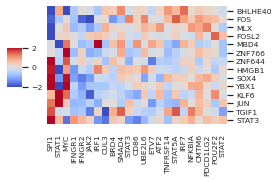

In [164]:
cg = sns.clustermap(
    filtered_res.fillna(0.0), center=0, cmap='coolwarm', z_score=0, vmax=2, vmin=-2, figsize=(4,3),
    xticklabels=1, yticklabels=1, cbar_pos=(0.05, 0.45, 0.05, 0.18))
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
cg.savefig('tf_ko_heatmap.png', dpi=300)

In [125]:
row_ind = cg.dendrogram_row.reordered_ind
col_ind = cg.dendrogram_col.reordered_ind

In [179]:
sns.set_style("white")


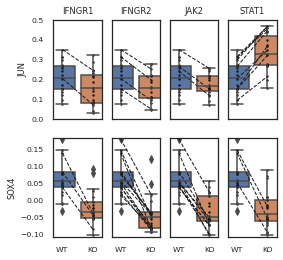

In [181]:
plt.figure(figsize=(4,4))
subidx=1
    
for tf in ['JUN', 'SOX4']:
    
    plt.subplots_adjust(wspace=.2)
    
    
    for idx1, ko in enumerate(['IFNGR1', 'IFNGR2', 'JAK2', 'STAT1']):
        plt.subplot(2, 4, subidx)
        subidx+=1
        
        subset = sc.read(data_path + '2d/hbec_validation_with_{}_KO_hbec_genes.h5ad'.format(ko))
        df = memento.get_2d_ht_result(subset)
        moments = memento.get_2d_moments(subset, groupby='is_ko')
        df = df.merge(moments, on=['gene_1', 'gene_2'])
        
        df['corr_fdr'] = memento.util._fdrcorrect(df['corr_pval'])
        
        plot_df = pd.melt(df.query('gene_1 == "{}"'.format(tf)), id_vars=['gene_1', 'gene_2'], value_vars=['is_ko_0', 'is_ko_1'])
        plot_df['tp'] = plot_df['variable'].apply(lambda x: x.split('_')[-1]).astype(int)
        
#         res.loc[tf, ko] = df.query('gene_1 == "{}"'.format(tf)).corr_coef.mean(skipna=True)
        
        if plot_df.shape[0] < 5:
            continue


#         plt.figure(figsize=(3,2))
        sns.boxplot(x='tp', y='value', data=plot_df)
        plt.scatter(plot_df['tp'], plot_df['value'], s=2, color='k')
        plt.xlim(-0.3, 1.3)

        for idx, row in df.query('corr_fdr < 0.15').query('gene_1 == "{}"'.format(tf)).iterrows():

            plt.plot([0, 1], [row['is_ko_0'], row['is_ko_1']], '--',lw=1, color='k')
        if tf == 'JUN':
            plt.title(ko)
            plt.xticks([])
        else:
            plt.xticks([0, 1], ['WT', 'KO'.format(ko)])

        plt.ylabel(None); 
        
        plt.xlabel(None)
        if idx1 > 0:
            plt.yticks([])
        if idx1 == 0:
            plt.ylabel(tf)
        
        if tf == 'JUN':
            plt.ylim(0, 0.5)
        if tf == 'SOX4':
            plt.ylim(-0.11, 0.18)
        
plt.savefig('tf_ko_examples.pdf', bbox_inches='tight')

In [115]:
df.query('gene_1 == "{}"'.format(tf)).corr_coef.mean()

-0.090773567487169

In [112]:
plot_df.groupby('variable').value.mean()

variable
is_ko_0    0.091633
is_ko_1    0.039900
Name: value, dtype: float64

In [105]:
ko = 'STAT1'

In [106]:
subset = sc.read(data_path + '2d/hbec_validation_with_{}_KO.h5ad'.format(ko))
df = memento.get_2d_ht_result(subset)
moments = memento.get_2d_moments(subset, groupby='is_ko')
df = df.merge(moments, on=['gene_1', 'gene_2'])

In [107]:
df['corr_fdr'] = memento.util._fdrcorrect(df['corr_pval'])

([<matplotlib.axis.XTick at 0x7f8c91f789a0>,
 [Text(0, 0, 'control'), Text(1, 0, 'STAT1 KO')])

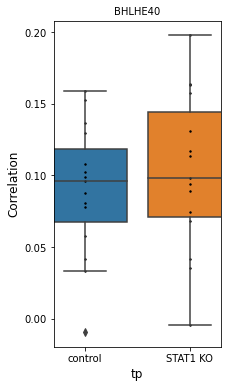

In [108]:
tf = 'BHLHE40'
plot_df = pd.melt(df.query('gene_1 == "{}"'.format(tf)), id_vars=['gene_1', 'gene_2'], value_vars=['is_ko_0', 'is_ko_1'])
plot_df['tp'] = plot_df['variable'].apply(lambda x: x.split('_')[-1]).astype(int)

plt.figure(figsize=(3,6))
sns.boxplot(x='tp', y='value', data=plot_df)
plt.scatter(plot_df['tp'], plot_df['value'], s=2, color='k')
plt.xlim(-0.3, 1.3)

for idx, row in df.query('corr_fdr < 0.15').query('gene_1 == "{}"'.format(tf)).iterrows():
    
    plt.plot([0, 1], [row['is_ko_0'], row['is_ko_1']], '--',lw=1, color='k')
plt.title(tf)
plt.ylabel('Correlation'); plt.xticks([0, 1], ['control', '{} KO'.format(ko)])

<AxesSubplot:>

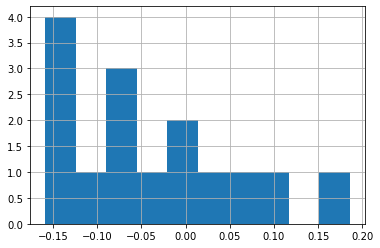

In [98]:
df.query('gene_1 == "BHLHE40"').corr_coef.hist()

In [189]:
df.sort_values('corr_fdr').query('corr_fdr < 0.15')

,gene_1,gene_2,corr_coef,corr_se,corr_pval,is_ko_0,is_ko_1,corr_fdr
128,HMGB1,BST2,-0.199343,0.044428,0.000326,0.276017,0.124397,0.021073
122,HMGB1,PSME1,-0.191940,0.047774,0.000559,0.315732,0.194747,0.021073
123,HMGB1,PSMB10,-0.214045,0.048371,0.000153,0.325889,0.177804,0.021073
106,HMGB1,PSMB9,-0.246103,0.060237,0.000602,0.482944,0.341601,0.021073
142,STAT3,HLA-B,0.233296,0.056218,0.000452,0.257203,0.405490,0.021073
113,HMGB1,EPSTI1,-0.187143,0.050381,0.000645,0.167672,0.076704,0.021073
111,HMGB1,UBE2L6,-0.228261,0.045238,0.000825,0.268161,0.119376,0.023088
136,HMGB1,GBP1,-0.164279,0.051020,0.001300,0.103544,0.035847,0.031847
108,HMGB1,LAP3,-0.169861,0.054944,0.001900,0.257162,0.158072,0.033851
129,HMGB1,IFITM3,-0.117607,0.035029,0.001892,0.068485,0.002001,0.033851


In [145]:
df

,tf,corr,pv,log10(P)
0,ZEB1,-0.010754,1.822114e-05,4.739424
1,ZNF576,-0.003043,2.700190e-01,0.568606
2,ID3,-0.020673,3.348955e-37,36.475091
3,PIAS3,0.009243,1.749945e-03,2.756975
4,RELB,0.006871,5.860634e-04,3.232055
...,...,...,...,...
564,CTCF,0.016217,4.595198e-12,11.337696
565,HMGXB4,-0.027201,4.256478e-23,22.370950
566,NFX1,0.025137,9.745075e-24,23.011215
567,LYL1,0.018275,3.630642e-16,15.440017


### same as HBEC analysisa

In [128]:
tf_df = pd.read_csv('../ifn_hbec/version3/baseline/human_tf.txt', sep='\t')
tf_df = tf_df.query('Family != "Others"')
tf_list = tf_df['Symbol'].tolist()
tf_list += ['CIITA', 'NLRC5']

In [129]:
def get_2d_ht(g, de_genes):
    
    subset = adata.copy().copy()

    subset = adata[adata.obs['gene'].isin(['NT', g]) & (adata.obs['treatment']=='tx')].copy().copy()

    subset.obs['is_ko'] = subset.obs.guide_ID.str.contains(g).astype(int).values

    memento.create_groups(subset, label_columns=['is_ko', 'replicate'])

    memento.compute_1d_moments(subset, min_perc_group=.7)

    available_tfs = list(set(tf_list) & set(subset.var.index))
    available_targets = list(set(thp1_isgs) & set(subset.var.index))
    memento.compute_2d_moments(subset, list(itertools.product(available_tfs, available_targets))   )
    
    return available_tfs, memento.get_2d_moments(subset, groupby='is_ko')

In [130]:
available_tfs, ko_result = get_2d_ht('STAT1', thp1_isgs)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [131]:
ko_result['diff'] = ko_result['is_ko_1'] - ko_result['is_ko_0']

In [132]:
df = []
for tf in available_tfs:
    pv = stats.ttest_1samp(ko_result.query('gene_1 == "{}"'.format(tf)).dropna()['diff'].values, popmean=0)[1]
    corr = ko_result.query('gene_1 == "{}"'.format(tf)).dropna()['diff'].values.mean()
    df.append((tf, corr, pv))    
    
df = pd.DataFrame(df, columns=['tf','corr', 'pv'])

In [135]:
df['log10(P)'] = -np.log10(df['pv'])

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, '-log10(P-value)')

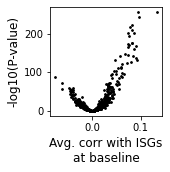

In [136]:
plt.figure(figsize=(2,2))
plt.scatter(df['corr'], df['log10(P)'], s=3, color='k')
plt.xlabel('Avg. corr with ISGs\nat baseline'); plt.ylabel('-log10(P-value)')
# plt.savefig('figures/control_tf_volcano.png', bbox_inches='tight', dpi=1000)

### Read self coexpression results

In [36]:
self_results = {}
for g in ko_genes:
#     print(g)
    if g == 'NT': continue
    try:
        subset = sc.read(data_path +'2d/{}_with_{}_KO.h5ad'.format(g,g))
    except:
        continue
    df = memento.get_2d_ht_result(subset)
    moments = memento.get_2d_moments(subset, groupby='is_ko')
    df = df.merge(moments, on=['gene_1', 'gene_2']).query('is_ko_0 > 0.3 | is_ko_0 < -0.3')
    df['corr_fdr'] = memento.util._fdrcorrect(df['corr_pval'])
    self_results[g] = df.copy()
    print(g, self_results[g].query('corr_fdr < 0.1 & ( (corr_coef < 0 & is_ko_0 > 0.3) | (corr_coef > 0 & is_ko_0 < -.3) )').shape[0])

IFNGR2 0
IFNGR1 137
JAK2 42
BRD4 0
SMAD4 0
STAT1 90
IRF1 51
STAT2 0
CUL3 1
MYC 0
SPI1 0


### Run 2D memento for self-DC genes

In [38]:
done_files = os.listdir(data_path + '2d/')
ko_genes = self_results.keys()
for g in ko_genes:
    
    for g_ko in ko_genes:
        print(g, g_ko)
        
        if g == g_ko or g == 'NT' or g_ko == 'NT': continue
        fname = '{}_with_{}_KO_DC.h5ad'.format(g, g_ko)
        if fname in done_files: continue
        
        subset = adata.copy().copy()

        subset = adata[adata.obs['gene'].isin(['NT', g_ko]) & (adata.obs['treatment']=='tx')].copy().copy()
    
        subset.obs['is_ko'] = subset.obs.guide_ID.str.contains(g_ko).values

        memento.create_groups(subset, label_columns=['is_ko', 'replicate'])

        memento.compute_1d_moments(subset, min_perc_group=.7)
        
        if g not in subset.var.index: continue

        available_genes = list(
            set(subset.var.index) & \
            set(self_results[g].query('corr_fdr < 0.1 & ( (corr_coef < 0 & is_ko_0 > 0.3) | (corr_coef > 0 & is_ko_0 < -.3) )').gene_2.tolist())            )
        
        if len(available_genes) < 10: continue
        memento.compute_2d_moments(subset, list(itertools.product([g], available_genes))   )

        memento.ht_2d_moments( 
            subset, 
            formula_like='1 + is_ko + replicate',
            treatment_col='is_ko', 
            num_boot=20000, 
            verbose=1,
            num_cpus=94,
            resampling='permutation',
            approx=True)
        
        subset.write(data_path + '2d/{}_with_{}_KO_DC.h5ad'.format(g, g_ko))

IFNGR2 IFNGR2
IFNGR2 IFNGR1
IFNGR2 JAK2
IFNGR2 BRD4
IFNGR2 SMAD4


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


IFNGR2 STAT1
IFNGR2 IRF1
IFNGR2 STAT2
IFNGR2 CUL3
IFNGR2 MYC
IFNGR2 SPI1
IFNGR1 IFNGR2


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  88 out of 137 | elapsed:   20.5s remaining:   11.4s
[Parallel(n_jobs=94)]: Done 137 out of 137 | elapsed:   27.8s finished
... storing 'memento_group' as categorical


IFNGR1 IFNGR1
IFNGR1 JAK2


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  88 out of 137 | elapsed:   14.7s remaining:    8.2s
[Parallel(n_jobs=94)]: Done 137 out of 137 | elapsed:   21.7s finished
... storing 'memento_group' as categorical


IFNGR1 BRD4


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  86 out of 136 | elapsed:   13.7s remaining:    7.9s
[Parallel(n_jobs=94)]: Done 136 out of 136 | elapsed:   19.9s finished
... storing 'memento_group' as categorical


IFNGR1 SMAD4


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  86 out of 136 | elapsed:   15.1s remaining:    8.8s
[Parallel(n_jobs=94)]: Done 136 out of 136 | elapsed:   21.3s finished
... storing 'memento_group' as categorical


IFNGR1 STAT1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  88 out of 137 | elapsed:   13.3s remaining:    7.4s
[Parallel(n_jobs=94)]: Done 137 out of 137 | elapsed:   18.8s finished
... storing 'memento_group' as categorical


IFNGR1 IRF1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  88 out of 137 | elapsed:   15.2s remaining:    8.5s
[Parallel(n_jobs=94)]: Done 137 out of 137 | elapsed:   21.2s finished
... storing 'memento_group' as categorical


IFNGR1 STAT2


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  88 out of 137 | elapsed:   15.9s remaining:    8.8s
[Parallel(n_jobs=94)]: Done 137 out of 137 | elapsed:   22.6s finished
... storing 'memento_group' as categorical


IFNGR1 CUL3


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  86 out of 136 | elapsed:   14.4s remaining:    8.3s
[Parallel(n_jobs=94)]: Done 136 out of 136 | elapsed:   20.1s finished
... storing 'memento_group' as categorical


IFNGR1 MYC


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  84 out of 135 | elapsed:   11.1s remaining:    6.7s
[Parallel(n_jobs=94)]: Done 135 out of 135 | elapsed:   15.8s finished
... storing 'memento_group' as categorical


IFNGR1 SPI1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


JAK2 IFNGR2


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  27 out of  42 | elapsed:    7.0s remaining:    3.9s
[Parallel(n_jobs=94)]: Done  42 out of  42 | elapsed:   10.3s finished
... storing 'memento_group' as categorical


JAK2 IFNGR1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  27 out of  42 | elapsed:    6.5s remaining:    3.6s
[Parallel(n_jobs=94)]: Done  42 out of  42 | elapsed:    9.5s finished
... storing 'memento_group' as categorical


JAK2 JAK2
JAK2 BRD4


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  27 out of  42 | elapsed:    6.0s remaining:    3.3s
[Parallel(n_jobs=94)]: Done  42 out of  42 | elapsed:    9.3s finished
... storing 'memento_group' as categorical


JAK2 SMAD4


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  27 out of  42 | elapsed:    6.8s remaining:    3.8s
[Parallel(n_jobs=94)]: Done  42 out of  42 | elapsed:    9.9s finished
... storing 'memento_group' as categorical


JAK2 STAT1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  27 out of  42 | elapsed:    5.8s remaining:    3.2s
[Parallel(n_jobs=94)]: Done  42 out of  42 | elapsed:    8.8s finished
... storing 'memento_group' as categorical


JAK2 IRF1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  27 out of  42 | elapsed:    6.9s remaining:    3.8s
[Parallel(n_jobs=94)]: Done  42 out of  42 | elapsed:   10.0s finished
... storing 'memento_group' as categorical


JAK2 STAT2


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  27 out of  42 | elapsed:    7.0s remaining:    3.9s
[Parallel(n_jobs=94)]: Done  42 out of  42 | elapsed:   10.1s finished
... storing 'memento_group' as categorical


JAK2 CUL3


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  22 out of  41 | elapsed:    5.8s remaining:    5.0s
[Parallel(n_jobs=94)]: Done  41 out of  41 | elapsed:    9.1s finished
... storing 'memento_group' as categorical


JAK2 MYC


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  17 out of  40 | elapsed:    5.4s remaining:    7.3s
[Parallel(n_jobs=94)]: Done  40 out of  40 | elapsed:    8.8s finished
... storing 'memento_group' as categorical


JAK2 SPI1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  16 out of  33 | elapsed:    4.7s remaining:    5.0s
[Parallel(n_jobs=94)]: Done  33 out of  33 | elapsed:    8.2s finished
... storing 'memento_group' as categorical


BRD4 IFNGR2


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


BRD4 IFNGR1
BRD4 JAK2
BRD4 BRD4
BRD4 SMAD4
BRD4 STAT1
BRD4 IRF1
BRD4 STAT2
BRD4 CUL3
BRD4 MYC
BRD4 SPI1
SMAD4 IFNGR2
SMAD4 IFNGR1
SMAD4 JAK2
SMAD4 BRD4
SMAD4 SMAD4
SMAD4 STAT1
SMAD4 IRF1
SMAD4 STAT2
SMAD4 CUL3
SMAD4 MYC
SMAD4 SPI1
STAT1 IFNGR2


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  85 out of  90 | elapsed:   29.0s remaining:    1.7s
[Parallel(n_jobs=94)]: Done  90 out of  90 | elapsed:   30.4s finished
... storing 'memento_group' as categorical


STAT1 IFNGR1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  85 out of  90 | elapsed:   26.9s remaining:    1.6s
[Parallel(n_jobs=94)]: Done  90 out of  90 | elapsed:   28.1s finished
... storing 'memento_group' as categorical


STAT1 JAK2


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  85 out of  90 | elapsed:   25.9s remaining:    1.5s
[Parallel(n_jobs=94)]: Done  90 out of  90 | elapsed:   27.2s finished
... storing 'memento_group' as categorical


STAT1 BRD4


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  82 out of  89 | elapsed:   23.6s remaining:    2.0s
[Parallel(n_jobs=94)]: Done  89 out of  89 | elapsed:   24.8s finished
... storing 'memento_group' as categorical


STAT1 SMAD4


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  85 out of  90 | elapsed:   25.0s remaining:    1.5s
[Parallel(n_jobs=94)]: Done  90 out of  90 | elapsed:   26.1s finished
... storing 'memento_group' as categorical


STAT1 STAT1
STAT1 IRF1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  85 out of  90 | elapsed:   24.9s remaining:    1.5s
[Parallel(n_jobs=94)]: Done  90 out of  90 | elapsed:   26.1s finished
... storing 'memento_group' as categorical


STAT1 STAT2


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  85 out of  90 | elapsed:   25.7s remaining:    1.5s
[Parallel(n_jobs=94)]: Done  90 out of  90 | elapsed:   26.6s finished
... storing 'memento_group' as categorical


STAT1 CUL3


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  82 out of  89 | elapsed:   22.3s remaining:    1.9s
[Parallel(n_jobs=94)]: Done  89 out of  89 | elapsed:   23.2s finished
... storing 'memento_group' as categorical


STAT1 MYC


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  70 out of  85 | elapsed:   19.3s remaining:    4.1s
[Parallel(n_jobs=94)]: Done  85 out of  85 | elapsed:   20.9s finished
... storing 'memento_group' as categorical


STAT1 SPI1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  25 out of  70 | elapsed:   11.3s remaining:   20.4s
[Parallel(n_jobs=94)]: Done  70 out of  70 | elapsed:   16.4s finished
... storing 'memento_group' as categorical


IRF1 IFNGR2


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  16 out of  50 | elapsed:   12.8s remaining:   27.2s
[Parallel(n_jobs=94)]: Done  50 out of  50 | elapsed:   19.3s finished
... storing 'memento_group' as categorical


IRF1 IFNGR1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  16 out of  50 | elapsed:   11.9s remaining:   25.4s
[Parallel(n_jobs=94)]: Done  50 out of  50 | elapsed:   18.4s finished
... storing 'memento_group' as categorical


IRF1 JAK2


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  16 out of  50 | elapsed:   11.7s remaining:   24.9s
[Parallel(n_jobs=94)]: Done  50 out of  50 | elapsed:   17.1s finished
... storing 'memento_group' as categorical


IRF1 BRD4


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  20 out of  51 | elapsed:   12.5s remaining:   19.4s
[Parallel(n_jobs=94)]: Done  51 out of  51 | elapsed:   17.0s finished
... storing 'memento_group' as categorical


IRF1 SMAD4


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  20 out of  51 | elapsed:   13.3s remaining:   20.7s
[Parallel(n_jobs=94)]: Done  51 out of  51 | elapsed:   16.9s finished
... storing 'memento_group' as categorical


IRF1 STAT1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  20 out of  51 | elapsed:   11.4s remaining:   17.7s
[Parallel(n_jobs=94)]: Done  51 out of  51 | elapsed:   15.9s finished
... storing 'memento_group' as categorical


IRF1 IRF1
IRF1 STAT2


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  20 out of  51 | elapsed:   13.4s remaining:   20.7s
[Parallel(n_jobs=94)]: Done  51 out of  51 | elapsed:   17.0s finished
... storing 'memento_group' as categorical


IRF1 CUL3


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  20 out of  51 | elapsed:   12.5s remaining:   19.4s
[Parallel(n_jobs=94)]: Done  51 out of  51 | elapsed:   16.3s finished
... storing 'memento_group' as categorical


IRF1 MYC


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done   1 tasks      | elapsed:    6.8s
[Parallel(n_jobs=94)]: Done  12 out of  49 | elapsed:   10.1s remaining:   31.2s
[Parallel(n_jobs=94)]: Done  49 out of  49 | elapsed:   14.1s finished
... storing 'memento_group' as categorical


IRF1 SPI1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done   1 tasks      | elapsed:    5.5s
[Parallel(n_jobs=94)]: Done  12 out of  49 | elapsed:    8.4s remaining:   26.0s
[Parallel(n_jobs=94)]: Done  49 out of  49 | elapsed:   13.3s finished
... storing 'memento_group' as categorical


STAT2 IFNGR2


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


STAT2 IFNGR1
STAT2 JAK2
STAT2 BRD4
STAT2 SMAD4
STAT2 STAT1
STAT2 IRF1
STAT2 STAT2
STAT2 CUL3
STAT2 MYC
STAT2 SPI1
CUL3 IFNGR2
CUL3 IFNGR1
CUL3 JAK2
CUL3 BRD4
CUL3 SMAD4
CUL3 STAT1
CUL3 IRF1
CUL3 STAT2
CUL3 CUL3
CUL3 MYC
CUL3 SPI1
MYC IFNGR2
MYC IFNGR1
MYC JAK2
MYC BRD4
MYC SMAD4
MYC STAT1
MYC IRF1
MYC STAT2
MYC CUL3
MYC MYC
MYC SPI1
SPI1 IFNGR2
SPI1 IFNGR1
SPI1 JAK2
SPI1 BRD4
SPI1 SMAD4
SPI1 STAT1
SPI1 IRF1
SPI1 STAT2
SPI1 CUL3
SPI1 MYC
SPI1 SPI1


### Check TF's correlation to other genes following KO

In [123]:
# subset_ko_genes = ['STAT1', 'STAT2', 'JAK2', 'CUL3', 'IFNGR1', 'IFNGR2', 'MYC', 'SMAD4']
done_files = os.listdir(data_path + '/2d/')
for g in ['JAK2']:#ko_genes:
    
    if g == 'NT': continue
    fname = '{}_with_{}_KO_guide_rep.h5ad'.format(g, g)
#         if fname in done_files: continue

    subset = adata.copy().copy()

    subset = adata[adata.obs['gene'].isin(['NT', g])].copy().copy()

    subset.obs['is_ko'] = subset.obs.guide_ID.str.contains(g).values

    memento.create_groups(subset, label_columns=['is_ko', 'replicate', 'guide_ID'])

    memento.compute_1d_moments(subset, min_perc_group=.7)

    if g not in subset.var.index: continue

    available_genes = list(set(subset.var.index))

    if len(available_genes) < 10: continue
    memento.compute_2d_moments(subset, list(itertools.product([g], available_genes))   )

    memento.ht_2d_moments( 
        subset, 
        formula_like='1 + is_ko + replicate',
        treatment_col='is_ko', 
        num_boot=10000, 
        verbose=1,
        num_cpus=14,
        resampling='bootstrap',
        approx=False)

    subset.write(data_path + '2d/{}_with_{}_KO_guide_rep.h5ad'.format(g, g))

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/estimator.py:106: RuntimeWarning: divide by zero encountered in log
  rv[cond] = np.exp(np.log(var[cond]) - f(np.log(mean[cond])))


In [124]:
moments, counts = memento.get_2d_moments(subset)

In [131]:
results['IFNGR1'].query('gene == "IFNGR1"')

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,de_fdr,dv_fdr
3183,IFNGR1,-0.150763,0.045791,0.001701,0.199772,0.201333,0.314369,0.006115,0.849193


In [127]:
dv_genes = results['JAK2'].query('dv_fdr < 0.1 & dv_coef > 0').gene.tolist()

In [120]:
subset.obs['STAT1'] = subset[:, 'STAT1'].X.todense().A1
subset.obs['GBP4'] = subset[:, 'GBP4'].X.todense().A1

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [70]:
dv_genes = results['STAT1'].query('dv_fdr < 0.1 & dv_coef > 0').gene.tolist()

### Debugging
